<a href="https://colab.research.google.com/github/quarcs-lab/pysalnarsc19/blob/master/content/320_local_autocorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers ##

In addition to the Global autocorrelation statistics, PySAL has many local
autocorrelation statistics. Let's compute a local Moran statistic for the same
dataset we used previously.



## Imports

# Setup

## Install libraries

In [1]:
!pip install -q geopandas
!pip install -q seaborn
!pip install -q shapely

     |████████████████████████████████| 931kB 2.7MB/s 
     |████████████████████████████████| 10.4MB 15.9MB/s 
     |████████████████████████████████| 14.7MB 50.1MB/s 


In [2]:
!pip install -q libpysal

     |████████████████████████████████| 2.4MB 2.8MB/s 


In [3]:
!pip install -q esda

     |████████████████████████████████| 71kB 2.1MB/s 


In [4]:
!pip install -q mapclassify

     |████████████████████████████████| 51kB 1.6MB/s 


In [5]:
!pip install -q splot

     |████████████████████████████████| 266kB 8.3MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 235kB 57.6MB/s 


In [0]:
!pip install -q legendgram

## Load libraries

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import geopandas
import shapely
import shapely.geometry as geom
import mapclassify
import legendgram
import splot
from splot.mapping import vba_choropleth
from splot._viz_utils import shift_colormap
import libpysal  as lp
from libpysal.weights import Queen, Rook, KNN, Kernel
import esda
# import contextily as ctx
# import rasterio as rio

## Load data from Github 

In [8]:
# It will be cloned for about a 12 hours. That is, you have to re-run this code only after 12 hours
 !git clone --recursive https://github.com/quarcs-lab/pysalnarsc19.git

Cloning into 'pysalnarsc19'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 410 (delta 43), reused 32 (delta 14), pack-reused 318
Receiving objects: 100% (410/410), 74.83 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Checking out files: 100% (155/155), done.


In [9]:
# Let us see what we have inside content/data Folder
 !ls pysalnarsc19/content/data

airbnb.cpg			  neighborhoods.csv
airbnb.dbf			  neighborhoods.gpkg
airbnb.prj			  neighbourhoods.geojson
airbnb.shp			  participants2016.csv
airbnb.shx			  participants2017.csv
airports.csv			  participants2018.csv
b500.cpg			  README.md
b500.dbf			  riverside_city.dbf
b500.prj			  riverside_city.prj
b500.shp			  riverside_city.qpj
b500.shx			  riverside_city.shp
behavioralHealth.dbf		  riverside_city.shx
behavioralHealth.prj		  san_diego.cpg
behavioralHealth.qpj		  san_diego.dbf
behavioralHealth.shp		  san_diego.prj
behavioralHealth.shx		  san_diego.shp
CAINC1__ALL_STATES_1969_2017.csv  san_diego.shx
CAINC1__definition.xml		  san_diego.tif
CAINC1__Footnotes.html		  sd_tracts_acs_clean.dbf
california_tracts.cpg		  sd_tracts_acs_clean.prj
california_tracts.dbf		  sd_tracts_acs_clean.qpj
california_tracts.prj		  sd_tracts_acs_clean.shp
california_tracts.shp		  sd_tracts_acs_clean.shx
california_tracts.shx		  texas.dbf
city_tracts.cpg			  texas.geojson
city_tracts.dbf			  texas.prj
city_t

In [0]:
# Load data (from cloned repository)
# db = geopandas.read_file('pysalnarsc19/content/data/texas.shp')

In [0]:
df = geopandas.read_file("pysalnarsc19/content/data/airbnb.shp")
np.random.seed(12345)

In [0]:
wq = lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'
lag_price = lp.weights.lag_spatial(wq, df['median_pri'])
y = df['median_pri']


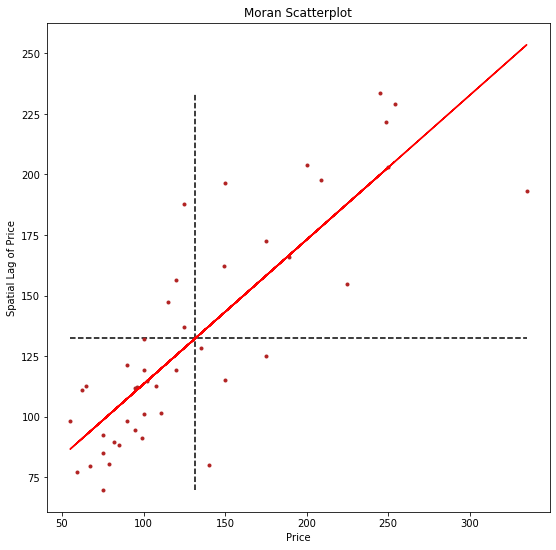

In [14]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()


Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

In [0]:
li = esda.moran.Moran_Local(y, wq)

In [16]:
li.q

array([4, 3, 1, 4, 3, 3, 3, 1, 1, 3, 3, 3, 3, 2, 4, 2, 4, 3, 2, 1, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 1, 1, 3, 3, 2, 3, 3, 1, 1])

We can again test for local clustering using permutations, but here we use
conditional random permutations (different distributions for each focal location)

In [17]:
(li.p_sim < 0.05).sum()

18

We can distinguish the specific type of local spatial association reflected in
the four quadrants of the Moran Scatterplot above:

In [0]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [0]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

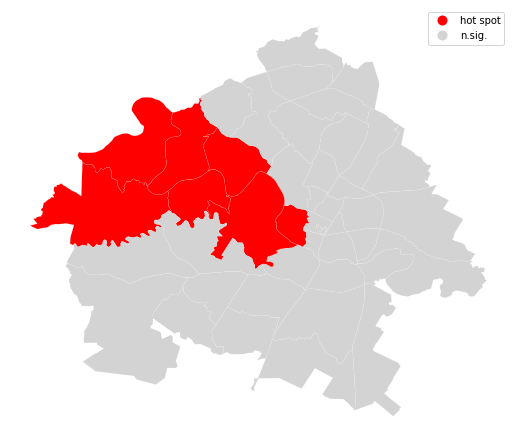

In [20]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [0]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

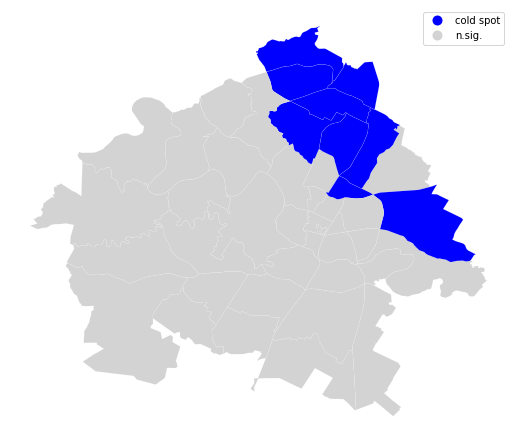

In [22]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [0]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

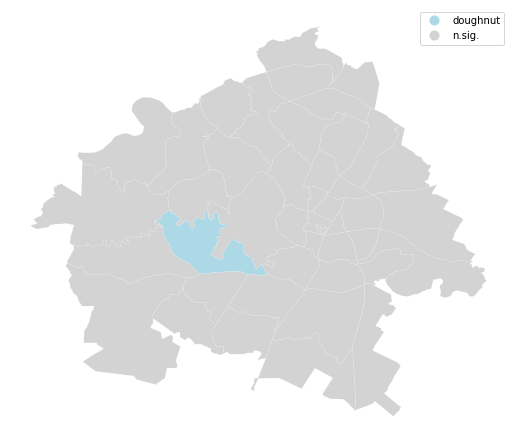

In [24]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [0]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

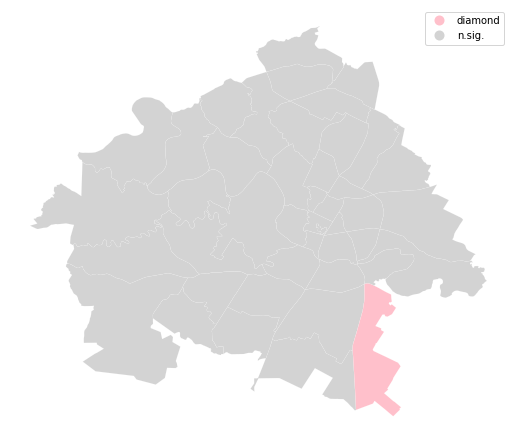

In [26]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [27]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 1, 3, 0,
       1, 0, 0, 0, 3, 3, 3, 0, 3, 0, 3, 1, 3, 0, 1, 0, 0, 2, 0, 3, 1, 0])

In [0]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

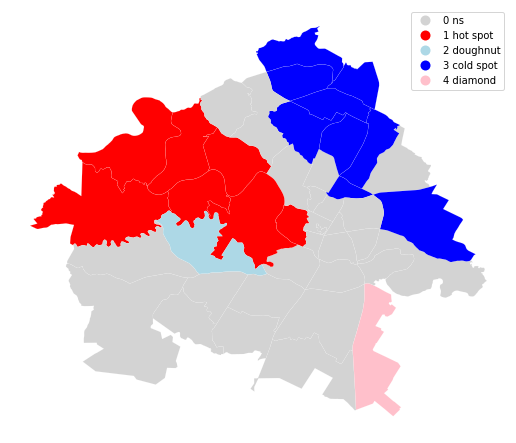

In [29]:

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

## Putting it all together

In [0]:
lisa = esda.Moran_Local(df["median_pri"], wq)

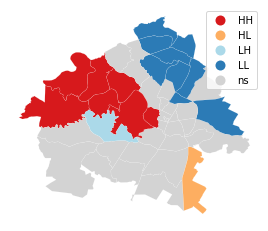

In [33]:
from splot import esda as esdaplot
esdaplot.lisa_cluster(lisa, df);

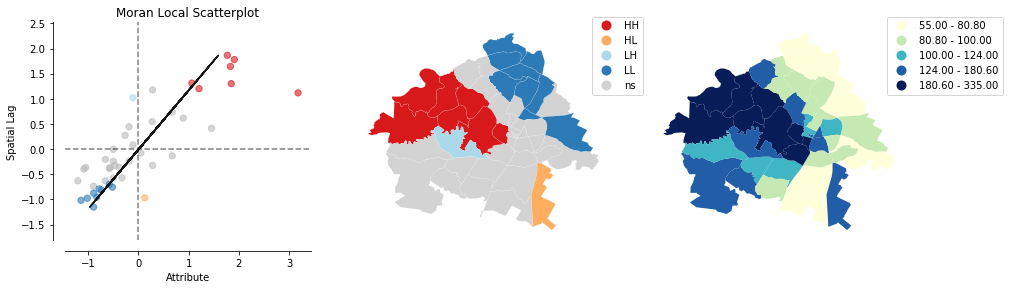

In [34]:
esdaplot.plot_local_autocorrelation(lisa, df, "median_pri");

## P-values revisited

In [0]:
lisa = esda.Moran_Local(df["median_pri"], wq)

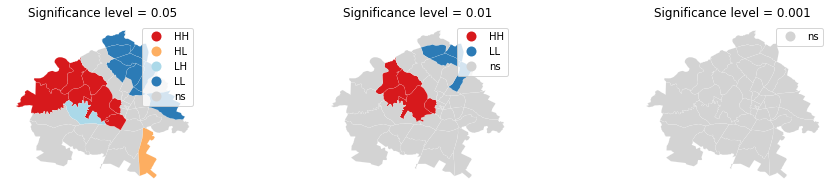

In [36]:
f, axs = plt.subplots(1, 3, figsize=(16, 3))
for i, ax in zip([0.05, 0.01, 0.001], axs):
    esdaplot.lisa_cluster(lisa, df, p=i, ax=ax)
    ax.set_title(f"Significance level = {i}")

<div class="alert alert-success" style="font-size:120%">
<b>Exercise</b>: <br>
Repeat the local analysis using rook contiguity and knn4. How do the results compare across different spatial weights?</div>

In [0]:
# %load solutions/320_1.py

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Local Spatial Autocorrelation</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.